## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import math

import warnings
warnings.simplefilter('ignore')

In [2]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

In [3]:
from_DB = True
path_to_feather = "..//..//data//feathers//" 

xcats = ['EQXR_NSA', 'FXXRUSD_NSA', 'FXCRYEUR_NSA', 'FXXREUR_NSA']

if from_DB:
    dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                              password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
    dfd = dbi.get_xcat(xcat=xcats, cross_section=cids, frequency="d")
    dfd.to_feather(f'{path_to_feather}dfd_fxrc_vin.ftr')
else:
    dfd = pd.read_feather(f'{path_to_feather}dfd_fxrc_vin.ftr')

KeyboardInterrupt: 

In [4]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429048 entries, 0 to 429047
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cross_section     429048 non-null  object 
 1   category_code     429048 non-null  object 
 2   adjustment        429048 non-null  object 
 3   transformation    0 non-null       object 
 4   release_date      429048 non-null  object 
 5   observation_date  429048 non-null  object 
 6   value             429048 non-null  float64
 7   grading           429048 non-null  object 
dtypes: float64(1), object(7)
memory usage: 26.2+ MB


In [5]:
[cid for cid in dfd['cross_section'].unique() if cid not in cids + cids_nou]  # check for new cross sections

[]

## Preparations

In [6]:
dfd_x = dfd[['cross_section', 'category_code', 'release_date']].sort_values('cross_section')
df_rstarts = dfd_x.groupby(['cross_section', 'category_code']).min()
df_rstarts['release_date'] = pd.DatetimeIndex(df_rstarts.loc[:,'release_date']).year
df_rstarts = df_rstarts.unstack().loc[:,'release_date']  # for availability

In [7]:
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 8))
    p1 = sns.scatterplot(x, y, data=data, size = 6, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
    # Set title and axis labels
    plt.title(title, fontdict = {'fontsize': 16})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

## Availability

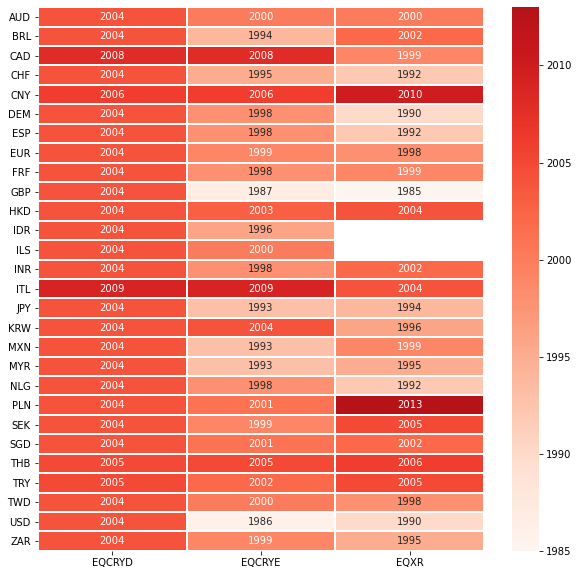

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_rstarts.sort_index(), 
            cmap='Reds', center=2002,
           annot=True, fmt='.0f', linewidth=1)
plt.xlabel('')
plt.ylabel('')
plt.show()

## Equity index returns

### Distribution

In [9]:
needed = ['cross_section', 'category_code', 'release_date', 'value']
filt1 = dfd['category_code'] == 'EQXR'
filt2 = dfd['release_date'] >= pd.to_datetime('01-06-1999')
filt3 = dfd['cross_section'].isin(cids)
dfd_eqr = dfd[filt1 & filt2 & filt3].sort_values(['cross_section', 'release_date'])[needed]\
    .reset_index(drop=True)

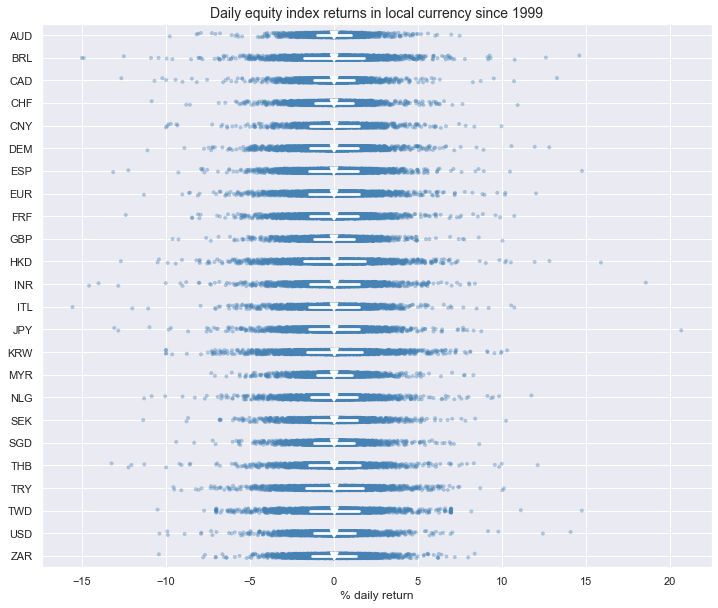

In [10]:
plt.figure(figsize=(12, 10))
sns.set(style='darkgrid')
ax = sns.stripplot(data=dfd_eqr, # show individual observations
                   x="value", y="cross_section",
                   dodge=True, alpha=.4, zorder=1, color='steelblue', size = 4)
sns.pointplot(data=dfd_eqr,  # show means/standard deviations
              x="value",  y="cross_section",
              dodge=.4, join=False, color='white',
              markers="v", scale=1, alpha=1, ci='sd')
ax.set_title('Daily equity index returns in local currency since 1999', y = 1, fontsize=14)
ax.set(xlabel='% daily return', ylabel='')
plt.grid(axis='y')
plt.show()

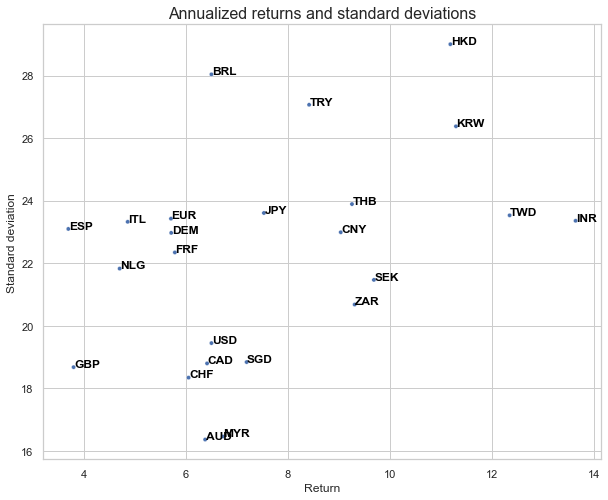

In [11]:
dfd_gpe = dfd_eqr.groupby('cross_section').agg(['mean', 'std'])
dfd_gpe.columns = ['Annualized mean', 'Annualized standard deviation']
dfd_gpe['Annualized mean'] = dfd_gpe['Annualized mean'] * 252
dfd_gpe['Annualized standard deviation'] = dfd_gpe['Annualized standard deviation'] * 252**0.5
scatter_text('Annualized mean', 'Annualized standard deviation', 'cross_section',
             data = dfd_gpe.reset_index(), 
             title = 'Annualized returns and standard deviations', 
             xlabel = 'Return',
             ylabel = 'Standard deviation')
plt.show()

### Timeline

In [12]:
dfd_eqr['cum_value'] = dfd_eqr.groupby('cross_section').cumsum()

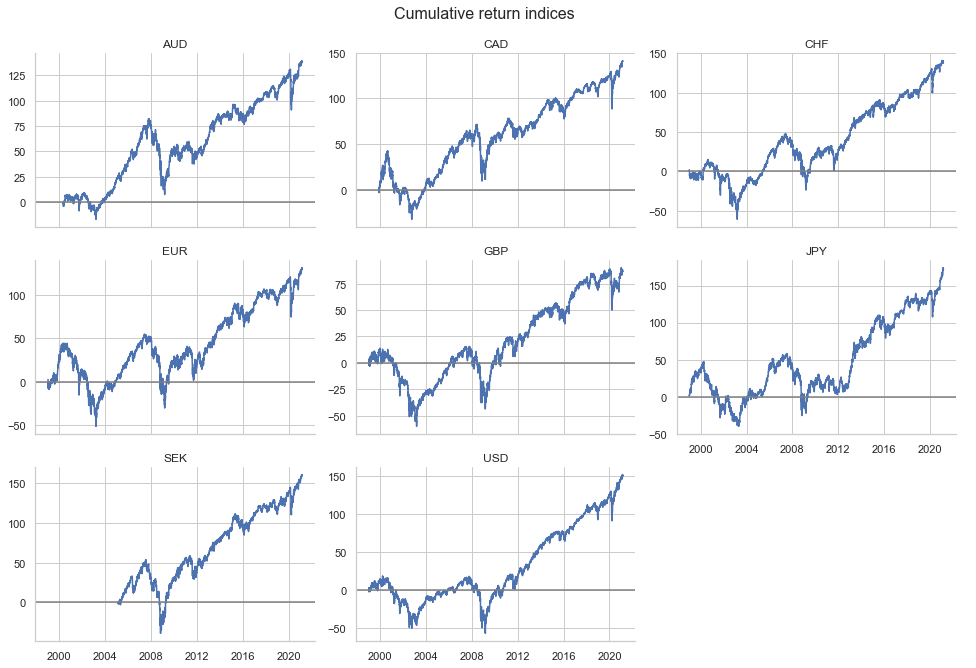

In [13]:
fg = sns.FacetGrid(dfd_eqr[dfd_eqr['cross_section'].isin(cids_dmx)], col='cross_section', 
                   col_wrap = 3, sharey=False, aspect = 1.5)
fg.map_dataframe(sns.lineplot, x='release_date', y='cum_value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.fig.suptitle("Cumulative return indices", size=16, y=1.03)
fg.add_legend()
plt.show()

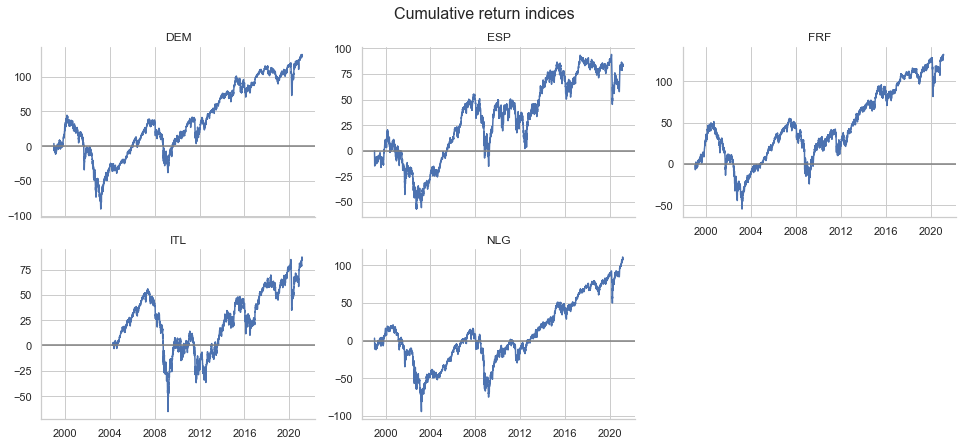

In [14]:
fg = sns.FacetGrid(dfd_eqr[dfd_eqr['cross_section'].isin(cids_eur)], col='cross_section', 
                   col_wrap = 3, sharey=False, aspect = 1.5)
fg.map_dataframe(sns.lineplot, x='release_date', y='cum_value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.fig.suptitle("Cumulative return indices", size=16, y=1.03)
fg.add_legend()
plt.show()

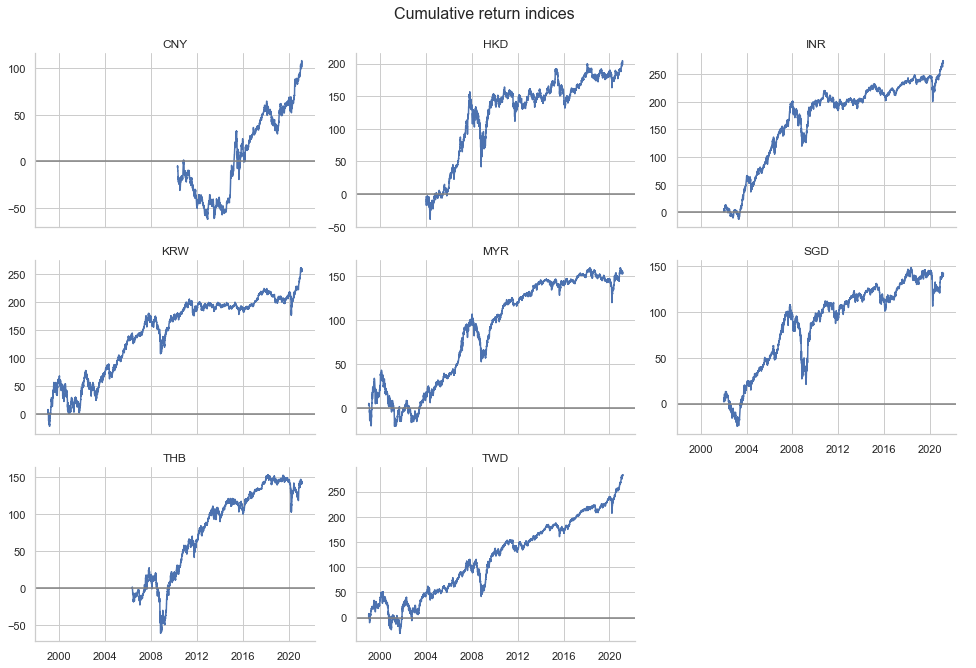

In [15]:
fg = sns.FacetGrid(dfd_eqr[dfd_eqr['cross_section'].isin(cids_asx)], col='cross_section', 
                   col_wrap = 3, sharey=False, aspect = 1.5)
fg.map_dataframe(sns.lineplot, x='release_date', y='cum_value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.fig.suptitle("Cumulative return indices", size=16, y=1.03)
fg.add_legend()
plt.show()

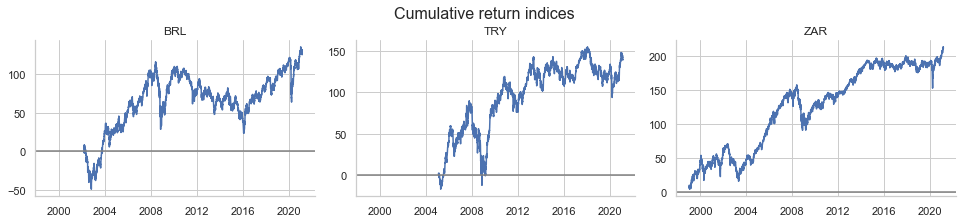

In [16]:
fg = sns.FacetGrid(dfd_eqr[dfd_eqr['cross_section'].isin(cids_exa)], col='cross_section', 
                   col_wrap = 3, sharey=False, aspect = 1.5)
fg.map_dataframe(sns.lineplot, x='release_date', y='cum_value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.fig.suptitle("Cumulative return indices", size=16, y=1.03)
fg.add_legend()
plt.show()

### Correlations

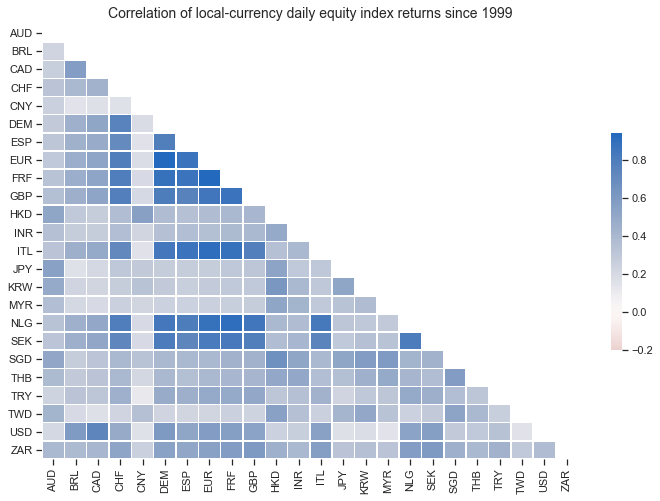

In [17]:
dfd_eqr_piv = dfd_eqr.pivot(index='release_date', columns='cross_section', values = 'value')
corr = dfd_eqr_piv.corr()  # compute correlation matrix

sns.set(rc={'figure.figsize':(12, 8)}, style="ticks") 
mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
ax = sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
                 square=False, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation of local-currency daily equity index returns since 1999', y = 1, fontsize=14)
ax.set(xlabel='', ylabel='')
plt.show()

## Carry measures

### Distribution

In [18]:
needed = ['cross_section', 'category_code', 'release_date', 'value']
filt1 = dfd['category_code'].isin(['EQCRYD', 'EQCRYE'])
filt2 = dfd['release_date'] >= pd.to_datetime('01-01-1999')
filt3 = dfd['cross_section'].isin(cids)
dfd_cry = dfd[filt1 & filt2 & filt3].sort_values(['cross_section', 'release_date'])[needed]\
    .reset_index(drop=True)

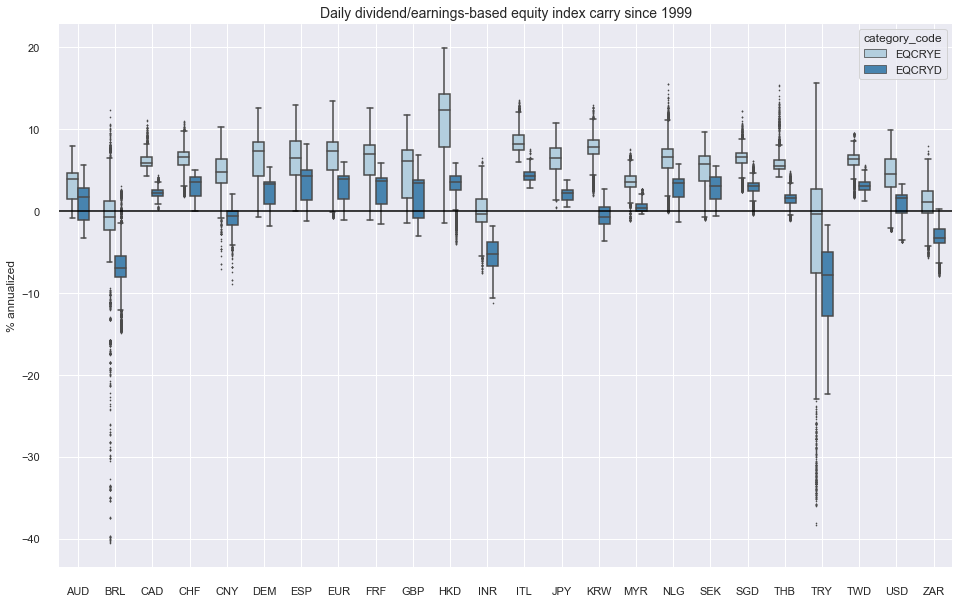

In [19]:
sns.set(rc={'figure.figsize':(16, 10)}, style="darkgrid")
ax = sns.boxplot(data=dfd_cry,
                 x="cross_section", y="value", hue='category_code', palette='Blues',
                 width=0.6, fliersize = 0.8)
sns.despine(offset=10, trim=False)
ax.set_title('Daily dividend/earnings-based equity index carry since 1999', y = 1, fontsize=14)
ax.set(xlabel='', ylabel='% annualized')
plt.grid(axis='x')
plt.axhline(color='black')
plt.show()

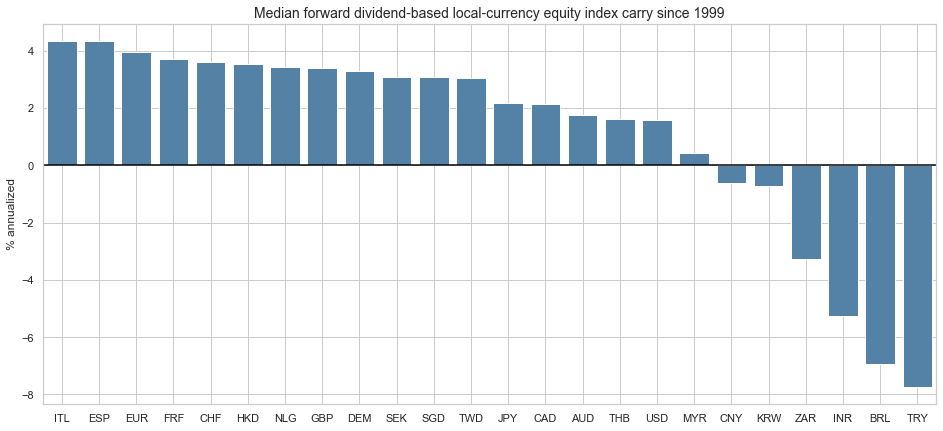

In [20]:
dfd_crd = dfd_cry[dfd_cry['category_code'] == 'EQCRYD'].groupby('cross_section').agg(['median']).reset_index()\
    .sort_values([('value', 'median')], ascending=False)
sns.set(rc={'figure.figsize':(16, 7)}, style = 'whitegrid')
ax = sns.barplot(data=dfd_crd, x='cross_section', y=('value', 'median'), color='steelblue')
ax.set_title('Median forward dividend-based local-currency equity index carry since 1999', y = 1, fontsize=14)
ax.set(xlabel='', ylabel='% annualized')
plt.grid(axis='x')
plt.axhline(color='black')
plt.show()

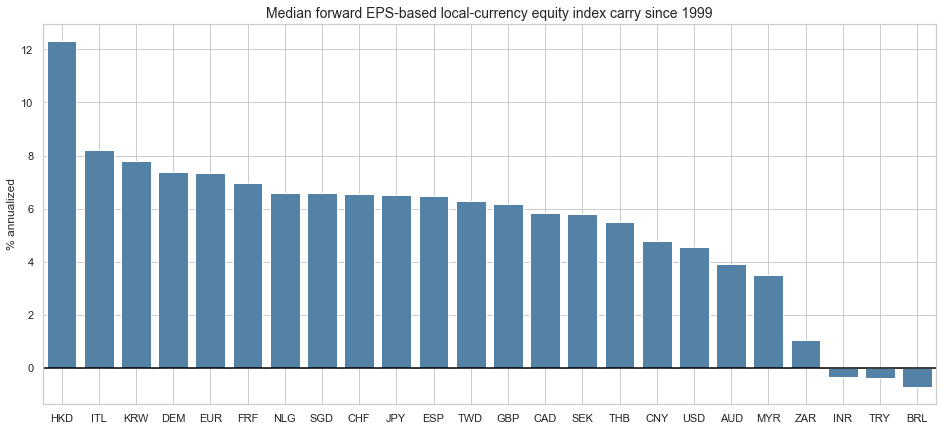

In [21]:
dfd_crd = dfd_cry[dfd_cry['category_code'] == 'EQCRYE'].groupby('cross_section').agg(['median']).reset_index()\
    .sort_values([('value', 'median')], ascending=False)
sns.set(rc={'figure.figsize':(16, 7)}, style = 'whitegrid')
ax = sns.barplot(data=dfd_crd, x='cross_section', y=('value', 'median'), color='steelblue')
ax.set_title('Median forward EPS-based local-currency equity index carry since 1999', y = 1, fontsize=14)
ax.set(xlabel='', ylabel='% annualized')
plt.grid(axis='x')
plt.axhline(color='black')
plt.show()

### Timeline

In [22]:
dfd_cry.head()

,cross_section,category_code,release_date,value
0,AUD,EQCRYE,2000-11-17,-0.437328
1,AUD,EQCRYE,2000-11-18,-0.480825
2,AUD,EQCRYE,2000-11-21,-0.470521
3,AUD,EQCRYE,2000-11-22,-0.428139
4,AUD,EQCRYE,2000-11-23,-0.417122


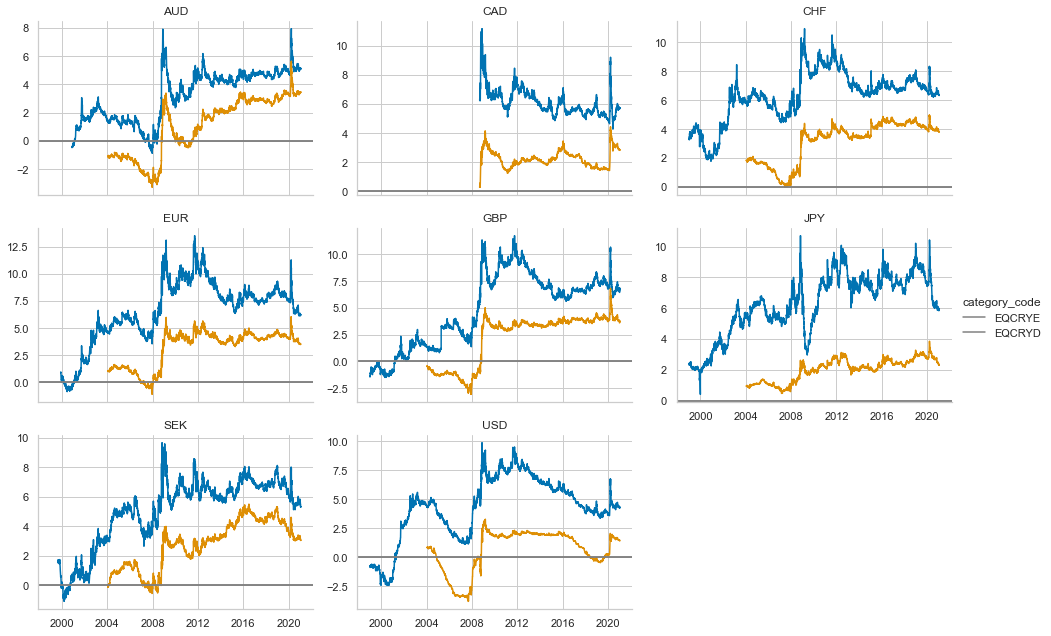

In [23]:
sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
fg = sns.FacetGrid(dfd_cry[dfd_cry['cross_section'].isin(cids_dmx)], col='cross_section', hue='category_code', 
                   col_wrap = 3, sharey=False, aspect = 1.5, palette='colorblind')
fg.map_dataframe(sns.lineplot, x='release_date', y='value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.add_legend()
plt.show()

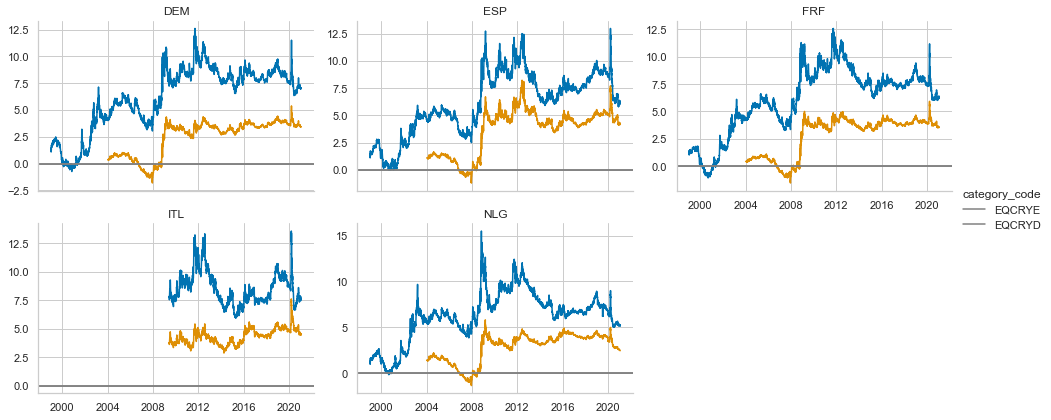

In [24]:
sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
fg = sns.FacetGrid(dfd_cry[dfd_cry['cross_section'].isin(cids_eur)], col='cross_section', hue='category_code', 
                   col_wrap = 3, sharey=False, aspect = 1.5, palette='colorblind')
fg.map_dataframe(sns.lineplot, x='release_date', y='value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.add_legend()
plt.show()

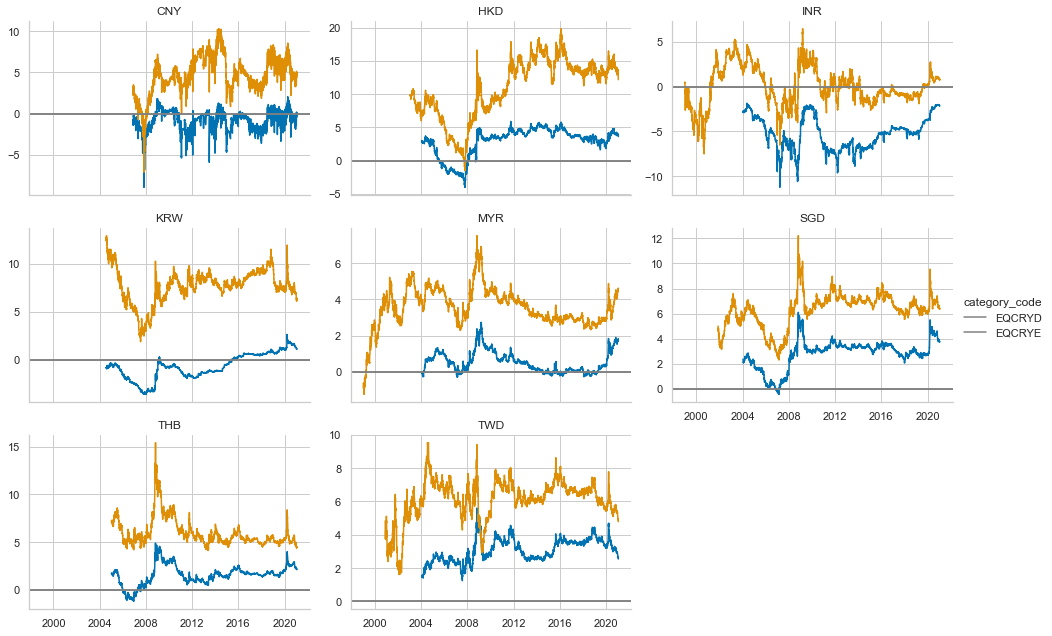

In [25]:
sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
fg = sns.FacetGrid(dfd_cry[dfd_cry['cross_section'].isin(cids_asx)], col='cross_section', hue='category_code', 
                   col_wrap = 3, sharey=False, aspect = 1.5, palette='colorblind')
fg.map_dataframe(sns.lineplot, x='release_date', y='value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.add_legend()
plt.show()

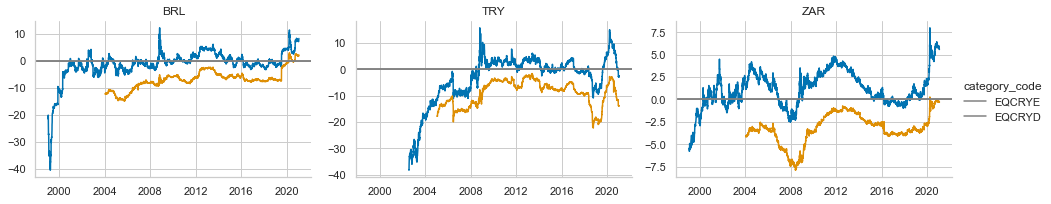

In [26]:
sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
fg = sns.FacetGrid(dfd_cry[dfd_cry['cross_section'].isin(cids_exa)], col='cross_section', hue='category_code', 
                   col_wrap = 3, sharey=False, aspect = 1.5, palette='colorblind')
fg.map_dataframe(sns.lineplot, x='release_date', y='value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.add_legend()
plt.show()

### Correlations

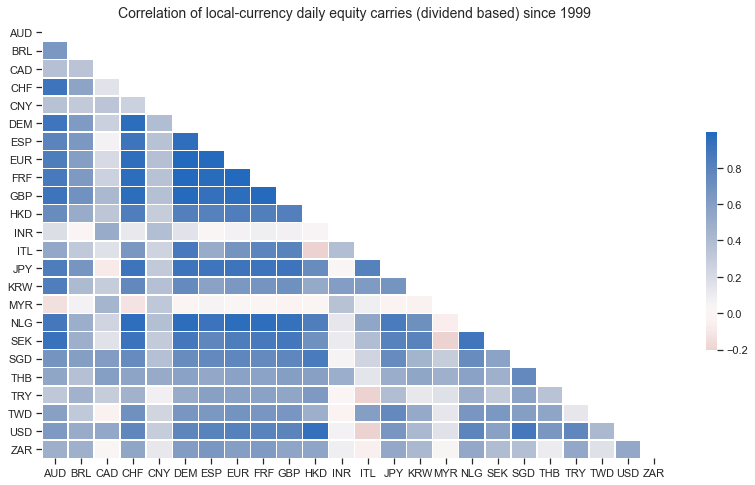

In [27]:
dfd_dcr_piv = dfd_cry[dfd_cry['category_code'] == 'EQCRYD'].pivot(index='release_date', columns='cross_section', values = 'value')
corr = dfd_dcr_piv.corr()  # compute correlation matrix

sns.set(rc={'figure.figsize':(14, 8)}, style="ticks") 
mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
ax = sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
                 square=False, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation of local-currency daily equity carries (dividend based) since 1999', y = 1, fontsize=14)
ax.set(xlabel='', ylabel='')
plt.show()

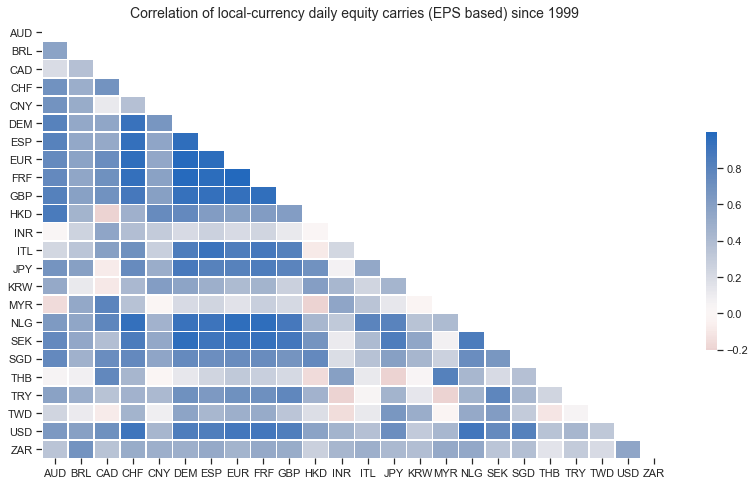

In [28]:
dfd_ecr_piv = dfd_cry[dfd_cry['category_code'] == 'EQCRYE'].pivot(index='release_date', columns='cross_section', values = 'value')
corr = dfd_ecr_piv.corr()  # compute correlation matrix

sns.set(rc={'figure.figsize':(14, 8)}, style="ticks") 
mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
ax = sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
                 square=False, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation of local-currency daily equity carries (EPS based) since 1999', y = 1, fontsize=14)
ax.set(xlabel='', ylabel='')
plt.show()